In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.arima.model import ARIMA

In [30]:
df_flux = pd.read_csv("data\input\\traindata.csv", sep = ",")
df_flux = df_flux.drop("Unnamed: 0", axis = 1)

In [31]:
## enlever 2023

df_flux = df_flux.drop(df_flux.index[df_flux["mois_annee_comptage"]== "2023-01-01"], axis = 0)

df_flux.name


0                           Voie Georges Pompidou
1               97 Avenue Denfert Rochereau SO-NE
2                        39 Quai François Mauriac
3              106 Avenue Denfert Rochereau NE-SO
4                      135 Avenue Daumesnil SE-NO
                          ...                    
3160                           Quai des Tuileries
3161                         254 rue de Vaugirard
3162                         30 rue Saint Jacques
3163             16 avenue de la Porte des Ternes
3164    Face au 16 avenue de la  Porte des Ternes
Name: name, Length: 3165, dtype: object

In [126]:
df_exemple = df_flux[df_flux["name"] == "Voie Georges Pompidou"]
df_exemple["mois_annee_comptage"] = df_exemple["mois_annee_comptage"].apply(lambda x: x[:-3])
df_exemple.index = df_exemple["mois_annee_comptage"]
# df_exemple = df_exemple.drop(["mois_annee_comptage", "name"], axis = 1)
df_exemple

,name,mois_annee_comptage,sum_counts
mois_annee_comptage,,,
2018-01,Voie Georges Pompidou,2018-01,6075.0
2018-02,Voie Georges Pompidou,2018-02,2275.0
2018-03,Voie Georges Pompidou,2018-03,17421.0
2018-04,Voie Georges Pompidou,2018-04,29823.0
2018-05,Voie Georges Pompidou,2018-05,35926.0
...,...,...,...
2022-08,Voie Georges Pompidou,2022-08,68338.0
2022-09,Voie Georges Pompidou,2022-09,108777.0
2022-10,Voie Georges Pompidou,2022-10,104891.0


In [127]:
def get_train_test(pd_data):

    train_size = int(len(pd_data) * 0.90)
    train, test = pd_data['sum_counts'][0:train_size], pd_data['sum_counts'][train_size:]

    return test, train

In [128]:
def pred_nombre_velos(y_train, y_test):
    ARIMAmodel = ARIMA(y_train, order = (12, 2, 2))
    ARIMAmodel.initialize_approximate_diffuse()
    ARIMAmodel = ARIMAmodel.fit()

    y_pred = ARIMAmodel.predict(start=len(y_train), end=len(y_test) + len(y_train)-1)

    return y_pred

def pred_nombre_velos_full(y_train, y_test):
    ARIMAmodel = ARIMA(y_train, order = (12, 2, 2))
    ARIMAmodel.initialize_approximate_diffuse()
    ARIMAmodel = ARIMAmodel.fit()

    y_pred = ARIMAmodel.predict(start=0, end=len(y_test) + len(y_train)-1)

    return y_pred


In [129]:
y_test, y_train = get_train_test(df_exemple)

print(y_test, y_train)

predictions= pred_nombre_velos(y_train, y_test)
predictions_full = pred_nombre_velos_full(y_train, y_test)


print(predictions)

print(predictions_full)



mois_annee_comptage
2022-06    101642.0
2022-07     89881.0
2022-08     68338.0
2022-09    108777.0
2022-10    104891.0
2022-11     88354.0
2022-12     53005.0
Name: sum_counts, dtype: float64 mois_annee_comptage
2018-01      6075.0
2018-02      2275.0
2018-03     17421.0
2018-04     29823.0
2018-05     35926.0
2018-06     38182.0
2018-07     40025.0
2018-08     27805.0
2018-09     52874.0
2018-10     47932.0
2018-11     32934.0
2018-12     24322.0
2019-01     27070.0
2019-02     34596.0
2019-03     37690.0
2019-04     45205.0
2019-05     49055.0
2019-06     54539.0
2019-07     64212.0
2019-08     47101.0
2019-09     76327.0
2019-10     55064.0
2019-11     43820.0
2019-12    106333.0
2020-01     95131.0
2020-02     48632.0
2020-03     29175.0
2020-04     15507.0
2020-05     83319.0
2020-06    117069.0
2020-07    116403.0
2020-08     70371.0
2020-09    126806.0
2020-10     85491.0
2020-11     61751.0
2020-12     51042.0
2021-01     55642.0
2021-02     34601.0
2021-03     31823.0
2021-04

# Visualisation des prédictions

In [77]:
[y_train.index[-1]] + list(predictions.index)

['2022-06-01', Timestamp('2022-07-01 00:00:00', freq='MS')]

Text(0, 0.5, 'Nb de vélos')

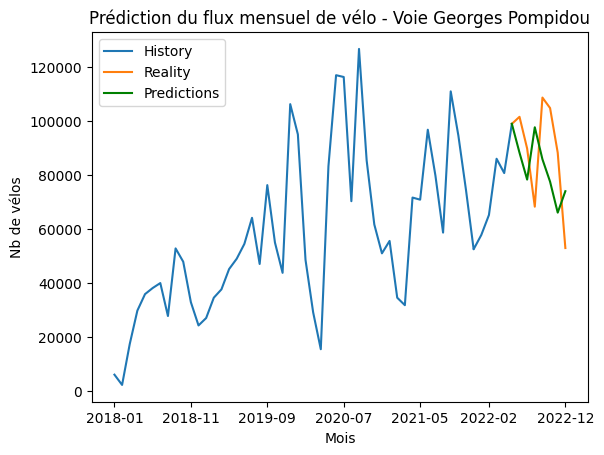

In [130]:
fig= plt.figure()
ax = fig.add_subplot(111)

ax.plot(y_train.index, y_train.values, label = 'History')
ax.plot([y_train.index[-1]] + list(y_test.index), [y_train.values[-1]] + list(y_test.values), label = 'Reality')
ax.plot([y_train.index[-1]] + list(y_test.index), [y_train.values[-1]] + list(predictions.values), color='Green', label = 'Predictions')
# plt.plot(df_exemple["mois_annee_comptage"],  list(predictions_full), color='Red', label = 'ARIMA Predictions')

plt.title('Prédiction du flux mensuel de vélo - Voie Georges Pompidou')
ax.legend()

xticks =np.array(df_exemple.index)[np.round(np.linspace(0, len(y_train) + len(y_test) - 1, 7)).astype(int)]
ax.set_xticks(xticks)

plt.xlabel('Mois')
plt.ylabel('Nb de vélos')


# Tuning Parameters

In [12]:
import warnings
from math import sqrt
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

C:\Users\guilh\AppData\Local\Temp\ipykernel_18164\526722019.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [8]:
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.90)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [9]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [28]:

# evaluate parameters
p_values = [10, 12]
d_values = range(2, 6)
q_values = range(2, 6)
warnings.filterwarnings("ignore")
evaluate_models(df_exemple["sum_counts"].values, p_values, d_values, q_values)

ARIMA(10, 2, 2) RMSE=609382870.078
ARIMA(10, 2, 3) RMSE=1250148698.832
ARIMA(10, 2, 4) RMSE=1978685374.438
ARIMA(10, 2, 5) RMSE=4059410337.284
ARIMA(10, 3, 2) RMSE=1891000462.432
ARIMA(10, 3, 3) RMSE=2543271863.337
ARIMA(10, 3, 4) RMSE=1758490524.614
ARIMA(10, 3, 5) RMSE=37270919600743.969
ARIMA(10, 4, 2) RMSE=1480531055.197
ARIMA(10, 4, 3) RMSE=1700571551.354
ARIMA(10, 4, 4) RMSE=2445473475.816
ARIMA(10, 4, 5) RMSE=1181271118.256
ARIMA(10, 5, 2) RMSE=1117591747.328
ARIMA(10, 5, 3) RMSE=906987938.112
ARIMA(10, 5, 4) RMSE=1769815039.688
ARIMA(10, 5, 5) RMSE=67802612948931780608.000
ARIMA(12, 2, 2) RMSE=343600004.670
ARIMA(12, 2, 3) RMSE=561917773.564
ARIMA(12, 2, 4) RMSE=771940133.303
ARIMA(12, 3, 2) RMSE=614143374.376
ARIMA(12, 3, 3) RMSE=726306929.936
ARIMA(12, 3, 4) RMSE=1472964479.972
ARIMA(12, 3, 5) RMSE=37268815359721.391
ARIMA(12, 4, 2) RMSE=1653173295.632
ARIMA(12, 4, 3) RMSE=2692260449.199
ARIMA(12, 4, 4) RMSE=2595543587.740
ARIMA(12, 4, 5) RMSE=1403714510.813
ARIMA(12, 5, 2) R